# Analyzing the QAOA Landscape for Different Graph Types

In this notebook, we will explore the Quantum Approximate Optimization Algorithm (QAOA) landscape for a variety of graph types. The QAOA is a quantum algorithm designed for solving combinatorial optimization problems and is particularly effective for problems that can be mapped onto graph structures.

## Objective

The main objective of this analysis is to understand how the QAOA performs on different graph types when the algorithm is set to a depth of \( p = 1 \). By investigating these landscapes, we can gain insights into the algorithm's behavior and performance across diverse graph structures.

## Graph Types

We will consider the following graph types in our analysis:
- Nearly Complete Bipartite Graph
- Uniform Random Graph
- Power Law Tree
- Watts-Strogatz Small World Graph
- 3-Regular Graph
- 4-Regular Graph
- Geometric Graph

Each of these graph types offers unique characteristics and challenges for optimization algorithms like QAOA.

## Methodology

For each graph type, we will:
1. Generate an instance of the graph.
2. Apply the QAOA with \( p = 1 \) to this instance.
3. Analyze and plot the QAOA landscape to observe the behavior of the algorithm.

## Tools and Libraries

We will use Python along with libraries such as NetworkX for graph generation and manipulation, and Qiskit for implementing and simulating the QAOA.

---

Let's begin by importing the necessary libraries and defining the array of graph types we will be analyzing.


In [15]:
node_size = 12
# WARNING THIS SIZE DOES CHANGE RUNTIME
MESH_SIZE = 400

In [16]:
import numpy as np
import networkx as nx
import pickle

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from qiskit import QuantumCircuit, Aer, execute
from qiskit.algorithms.optimizers import COBYLA, ADAM
from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit.utils import QuantumInstance
from qiskit_optimization.applications import Maxcut
from qiskit.opflow import AerPauliExpectation, PauliSumOp
from qiskit.quantum_info import Statevector
from qiskit.circuit import Parameter

# Custom imports
from qaoa_vrp.parallel.landscape_parallel import parallel_computation
from qaoa_vrp.generators.graph_instance import create_graphs_from_all_sources

# Set a global style
plt.style.use('default')

In [17]:
G_instances = create_graphs_from_all_sources(instance_size=node_size, sources="ALL")

Guess 1 for producing a connected Geometric Graph with r=0.48102057433075074 - connected: True


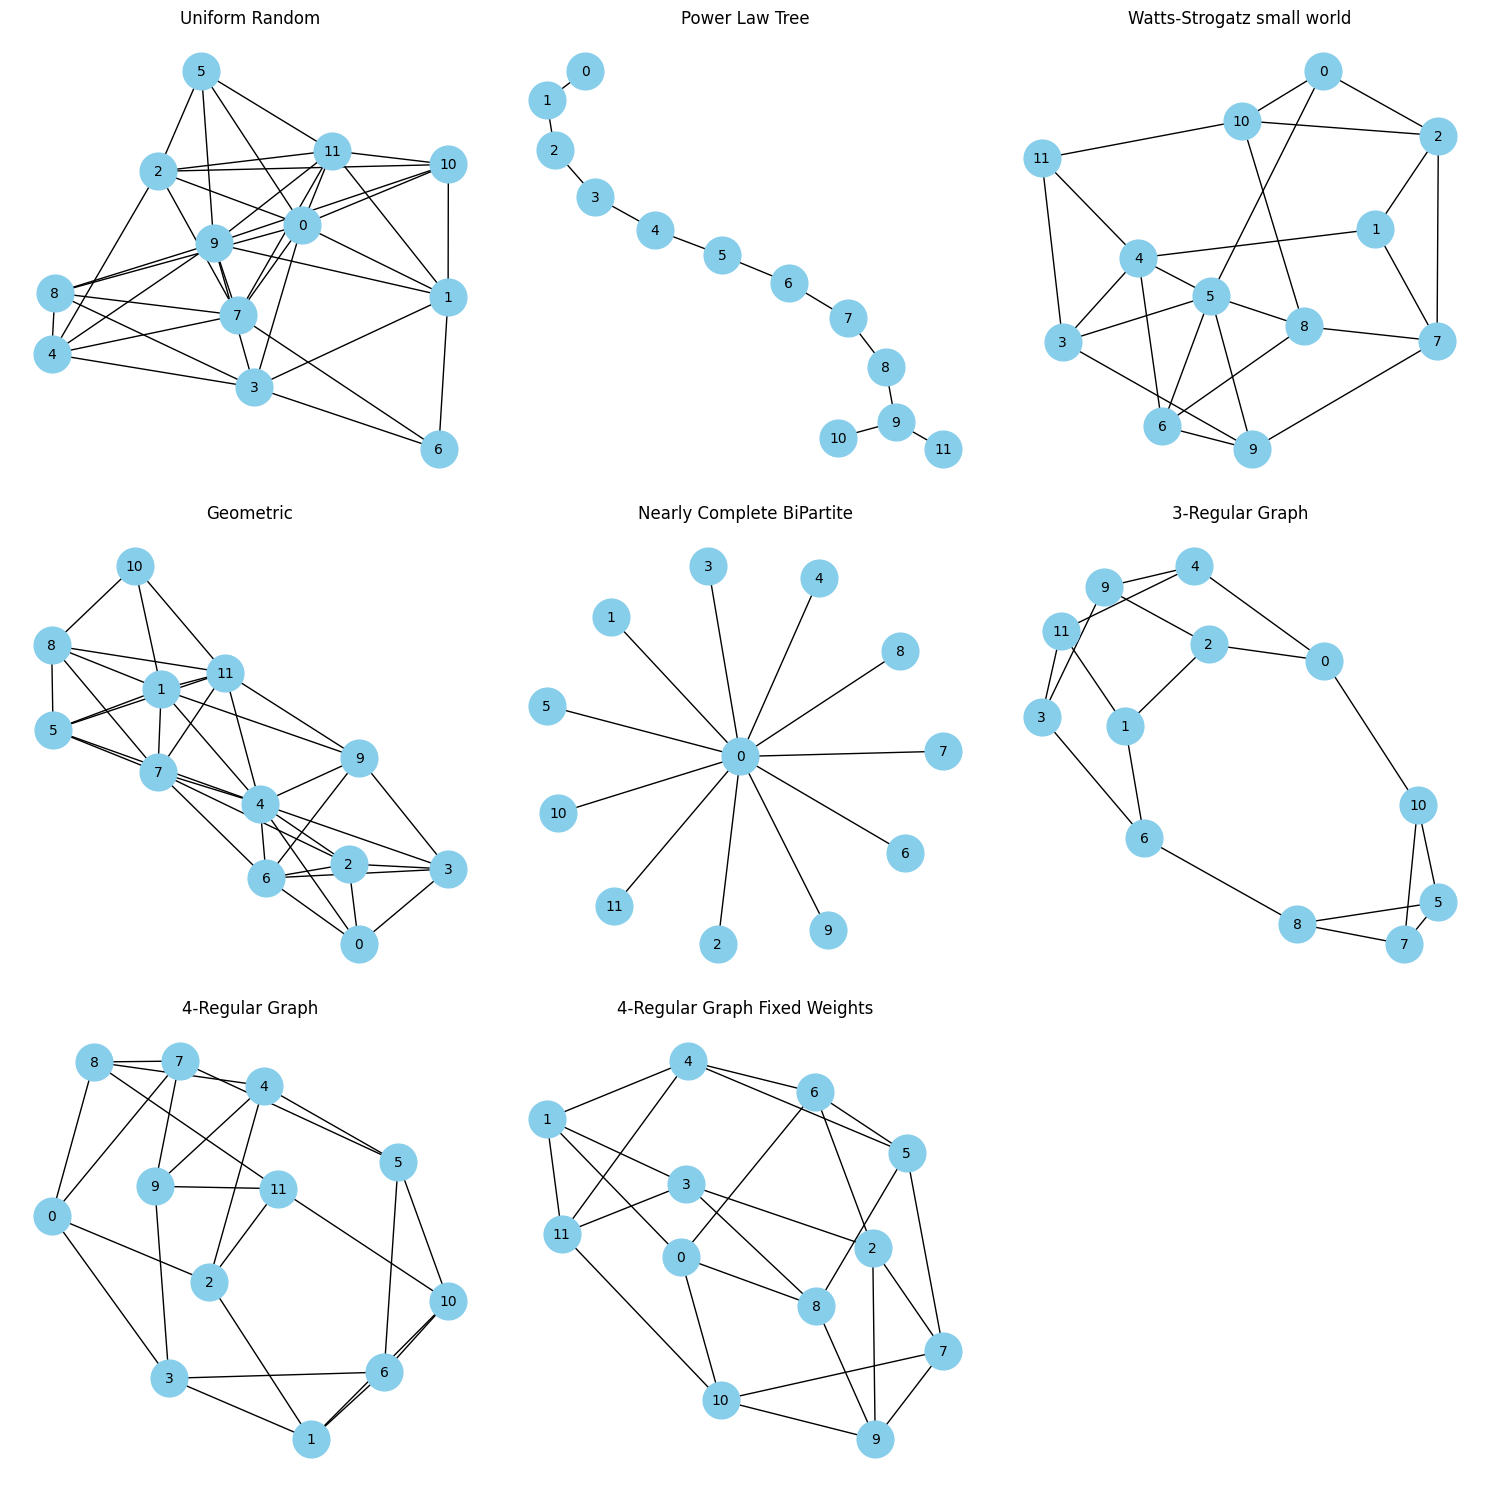

In [18]:
# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
axes = axes.flatten()

# Plot each graph type
for i, graph_type in enumerate(G_instances):
    graph = graph_type.G
    ax = axes[i]
    nx.draw(graph, ax=ax, with_labels=True, node_size=700, node_color="skyblue", font_size=10)
    ax.set_title(graph_type.graph_type)

# Adjust layout and remove unused subplots
for ax in axes[i+1:]:
    ax.axis('off')
plt.tight_layout()
plt.show()

In [19]:
# Helper function to format tick labels
def format_pi_labels(ticks):
    labels = []
    for val in ticks:
        # Factor out pi for labeling
        n_pi = val / np.pi
        
        # Check for whole numbers and halves
        if val == 0:
            labels.append("$0$")
        elif n_pi.is_integer():
            n_pi = int(n_pi)  # Convert to integer if whole number
            labels.append(f"${n_pi}\\pi$" if n_pi != 1 else r"$\pi$")
        elif (n_pi * 2).is_integer():
            n_half_pi = int(n_pi * 2)
            labels.append(r"$\frac{" + f"{n_half_pi}" + r"}{2}\pi$")
        elif (n_pi * 4).is_integer():
            n_quarter_pi = int(n_pi * 4)
            if n_quarter_pi == 1 or n_quarter_pi == -1:
                labels.append(f"${n_quarter_pi}\\frac{{\pi}}{{4}}$")
            else:
                labels.append(r"$\frac{" + f"{n_quarter_pi}" + r"}{4}\pi$")
        else:
            labels.append(f"{val:.2f}")
    return labels


def plot_landscape(landscape_data: dict, show_ticks: bool = True):
    """
    Generate a 2D contour plot from the landscape data and return the figure and axes objects.

    Parameters:
    landscape_data : dict
        A dictionary containing the beta, gamma, and objective values.
        Expected keys: 'beta', 'gamma', 'obj_vals'
    show_ticks : bool, default True
        Whether to show tick marks on the plot.

    Returns:
    fig, ax : tuple
        A tuple containing the figure and axes objects.
    """

    beta = landscape_data['beta']
    gamma = landscape_data['gamma']
    obj_vals = landscape_data['obj_vals']

    # Creating a figure and an axis
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plotting the data
    im = ax.imshow(obj_vals.T, origin='lower', cmap='viridis', extent=(beta[0], beta[-1], gamma[0], gamma[-1]))

    # Setting labels with LaTeX-style
    ax.set_xlabel(r'$\beta$' if show_ticks else '')
    ax.set_ylabel(r'$\gamma$' if show_ticks else '')

    if show_ticks:
        # Setting ticks based on the bounds of beta and gamma
        beta_ticks = np.linspace(beta[0], beta[-1], 5)
        gamma_ticks = np.linspace(gamma[0], gamma[-1], 5)
        ax.set_xticks(beta_ticks)
        ax.set_yticks(gamma_ticks)

        # Formatting tick labels to include pi symbol using LaTeX
        beta_tick_labels = format_pi_labels(beta_ticks)
        gamma_tick_labels = format_pi_labels(gamma_ticks)
        ax.set_xticklabels(beta_tick_labels)
        ax.set_yticklabels(gamma_tick_labels)
    else:
        # Turn off ticks
        ax.set_xticks([])
        ax.set_yticks([])

    # Adding a colorbar
    plt.colorbar(im, ax=ax)

    # Return the figure and axes objects
    return fig, ax

In [20]:
def build_landscape_plot(G, mesh_size: int = 10, beta_lb: float = -2 * np.pi, beta_ub: float = 2 * np.pi, gamma_lb: float = -2 * np.pi, gamma_ub: float = 2 * np.pi) -> dict:
    """
    Build a landscape plot for the QAOA applied to the Maxcut problem on a given graph.

    Parameters:
    G : networkx.Graph
        The graph for which the QAOA landscape is being computed.
    mesh_size : int
        The number of points in the mesh grid for beta and gamma.
    beta_lb : float, default -2*pi
        The lower bound for the beta parameter.
    beta_ub : float, default 2*pi
        The upper bound for the beta parameter.
    gamma_lb : float, default -2*pi
        The lower bound for the gamma parameter.
    gamma_ub : float, default 2*pi
        The upper bound for the gamma parameter.

    Returns:
    dict
        A dictionary containing the beta, gamma, and objective values for the QAOA applied to Maxcut.
    """
    # Convert graph to adjacency matrix and setup Maxcut
    adjacency_matrix = nx.adjacency_matrix(G)
    max_cut = Maxcut(adjacency_matrix)
    qubitOp, offset = max_cut.to_quadratic_program().to_ising()

    # Define QAOA parameters
    p = 1  # Number of QAOA layers, adjust as needed
    gamma = Parameter('γ')
    beta = Parameter('β')

    # Initialize the QAOA circuit with the parameters
    qaoa = QAOA(optimizer=COBYLA(), reps=p, initial_point=[gamma, beta])

    # Create linspace for beta and gamma
    beta_vals = np.linspace(beta_lb, beta_ub, mesh_size)
    gamma_vals = np.linspace(gamma_lb, gamma_ub, mesh_size)

    # Perform parallel computation (assuming implementation exists)
    obj_vals = parallel_computation(beta_vals, gamma_vals, qubitOp, qaoa)
    
    return {'beta': beta_vals, 'gamma': gamma_vals, 'obj_vals': obj_vals}

In [23]:
# Dictionary to store the landscape data for each graph
landscape_data_storage = {}

# Loop through each graph and its type
for i, graph_data in enumerate(G_instances, start=1):
    G = graph_data.G
    graph_type = graph_data.graph_type
    
    print(f"Processing graph {i}/{len(G_instances)} - Type: {graph_type}")
    
    if graph_type in ['Power Law Tree', 'Watts-Strogatz small world', 'Geometric', "Uniform Random"]:
        landscape_data = build_landscape_plot(
            G,
            mesh_size=MESH_SIZE,
            beta_lb=-np.pi,
            beta_ub=np.pi,
            gamma_lb=0,
            gamma_ub=np.pi
        )
    elif graph_type in ['Nearly Complete BiPartite', '3-Regular Graph', '4-Regular Graph', '4-Regular Graph Fixed Weights']:
        landscape_data = build_landscape_plot(
            G,
            mesh_size=MESH_SIZE,
            beta_lb=-np.pi/2,
            beta_ub=np.pi/2,
            gamma_lb=0,
            gamma_ub=np.pi
        )
    else:
        continue  # Skip graph types that are not listed
    
    # Store the landscape data with a unique identifier for the graph
    landscape_data_storage[f"Graph_{i}_{graph_type}"] = landscape_data
    
    print(f"Graph {i} processing completed.")

# Write the landscape data storage to a pickle file
pickle_filename = 'landscape_data_storage.pkl'
with open(pickle_filename, 'wb') as handle:
    pickle.dump(landscape_data_storage, handle, protocol=pickle.HIGHEST_PROTOCOL)

print(f"All landscape data have been saved to {pickle_filename}.")

Processing graph 1/8 - Type: Uniform Random


/var/folders/gb/rc_0v1v93713yw2vssbh8vw40000gn/T/ipykernel_80359/1136190822.py:24: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_matrix = nx.adjacency_matrix(G)
Progress: 100%|█████████████████████████████████████████████████| 160000/160000 [4:07:44<00:00, 10.76it/s]


Graph 1 processing completed.
Processing graph 2/8 - Type: Power Law Tree


/var/folders/gb/rc_0v1v93713yw2vssbh8vw40000gn/T/ipykernel_80359/1136190822.py:24: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_matrix = nx.adjacency_matrix(G)
Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160000/160000 [1:50:33<00:00, 24.12it/s]


Graph 2 processing completed.
Processing graph 3/8 - Type: Watts-Strogatz small world


/var/folders/gb/rc_0v1v93713yw2vssbh8vw40000gn/T/ipykernel_80359/1136190822.py:24: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_matrix = nx.adjacency_matrix(G)
Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160000/160000 [2:24:09<00:00, 18.50it/s]


Graph 3 processing completed.
Processing graph 4/8 - Type: Geometric


/var/folders/gb/rc_0v1v93713yw2vssbh8vw40000gn/T/ipykernel_80359/1136190822.py:24: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_matrix = nx.adjacency_matrix(G)
Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160000/160000 [2:45:16<00:00, 16.13it/s]


Graph 4 processing completed.
Processing graph 5/8 - Type: Nearly Complete BiPartite


/var/folders/gb/rc_0v1v93713yw2vssbh8vw40000gn/T/ipykernel_80359/1136190822.py:24: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_matrix = nx.adjacency_matrix(G)
Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160000/160000 [1:50:33<00:00, 24.12it/s]


Graph 5 processing completed.
Processing graph 6/8 - Type: 3-Regular Graph


/var/folders/gb/rc_0v1v93713yw2vssbh8vw40000gn/T/ipykernel_80359/1136190822.py:24: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_matrix = nx.adjacency_matrix(G)
Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160000/160000 [2:09:24<00:00, 20.61it/s]


Graph 6 processing completed.
Processing graph 7/8 - Type: 4-Regular Graph


/var/folders/gb/rc_0v1v93713yw2vssbh8vw40000gn/T/ipykernel_80359/1136190822.py:24: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_matrix = nx.adjacency_matrix(G)
Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160000/160000 [2:23:35<00:00, 18.57it/s]


Graph 7 processing completed.
Processing graph 8/8 - Type: 4-Regular Graph Fixed Weights


/var/folders/gb/rc_0v1v93713yw2vssbh8vw40000gn/T/ipykernel_80359/1136190822.py:24: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adjacency_matrix = nx.adjacency_matrix(G)
Progress: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 160000/160000 [2:23:39<00:00, 18.56it/s]


Graph 8 processing completed.
All landscape data have been saved to landscape_data_storage.pkl.


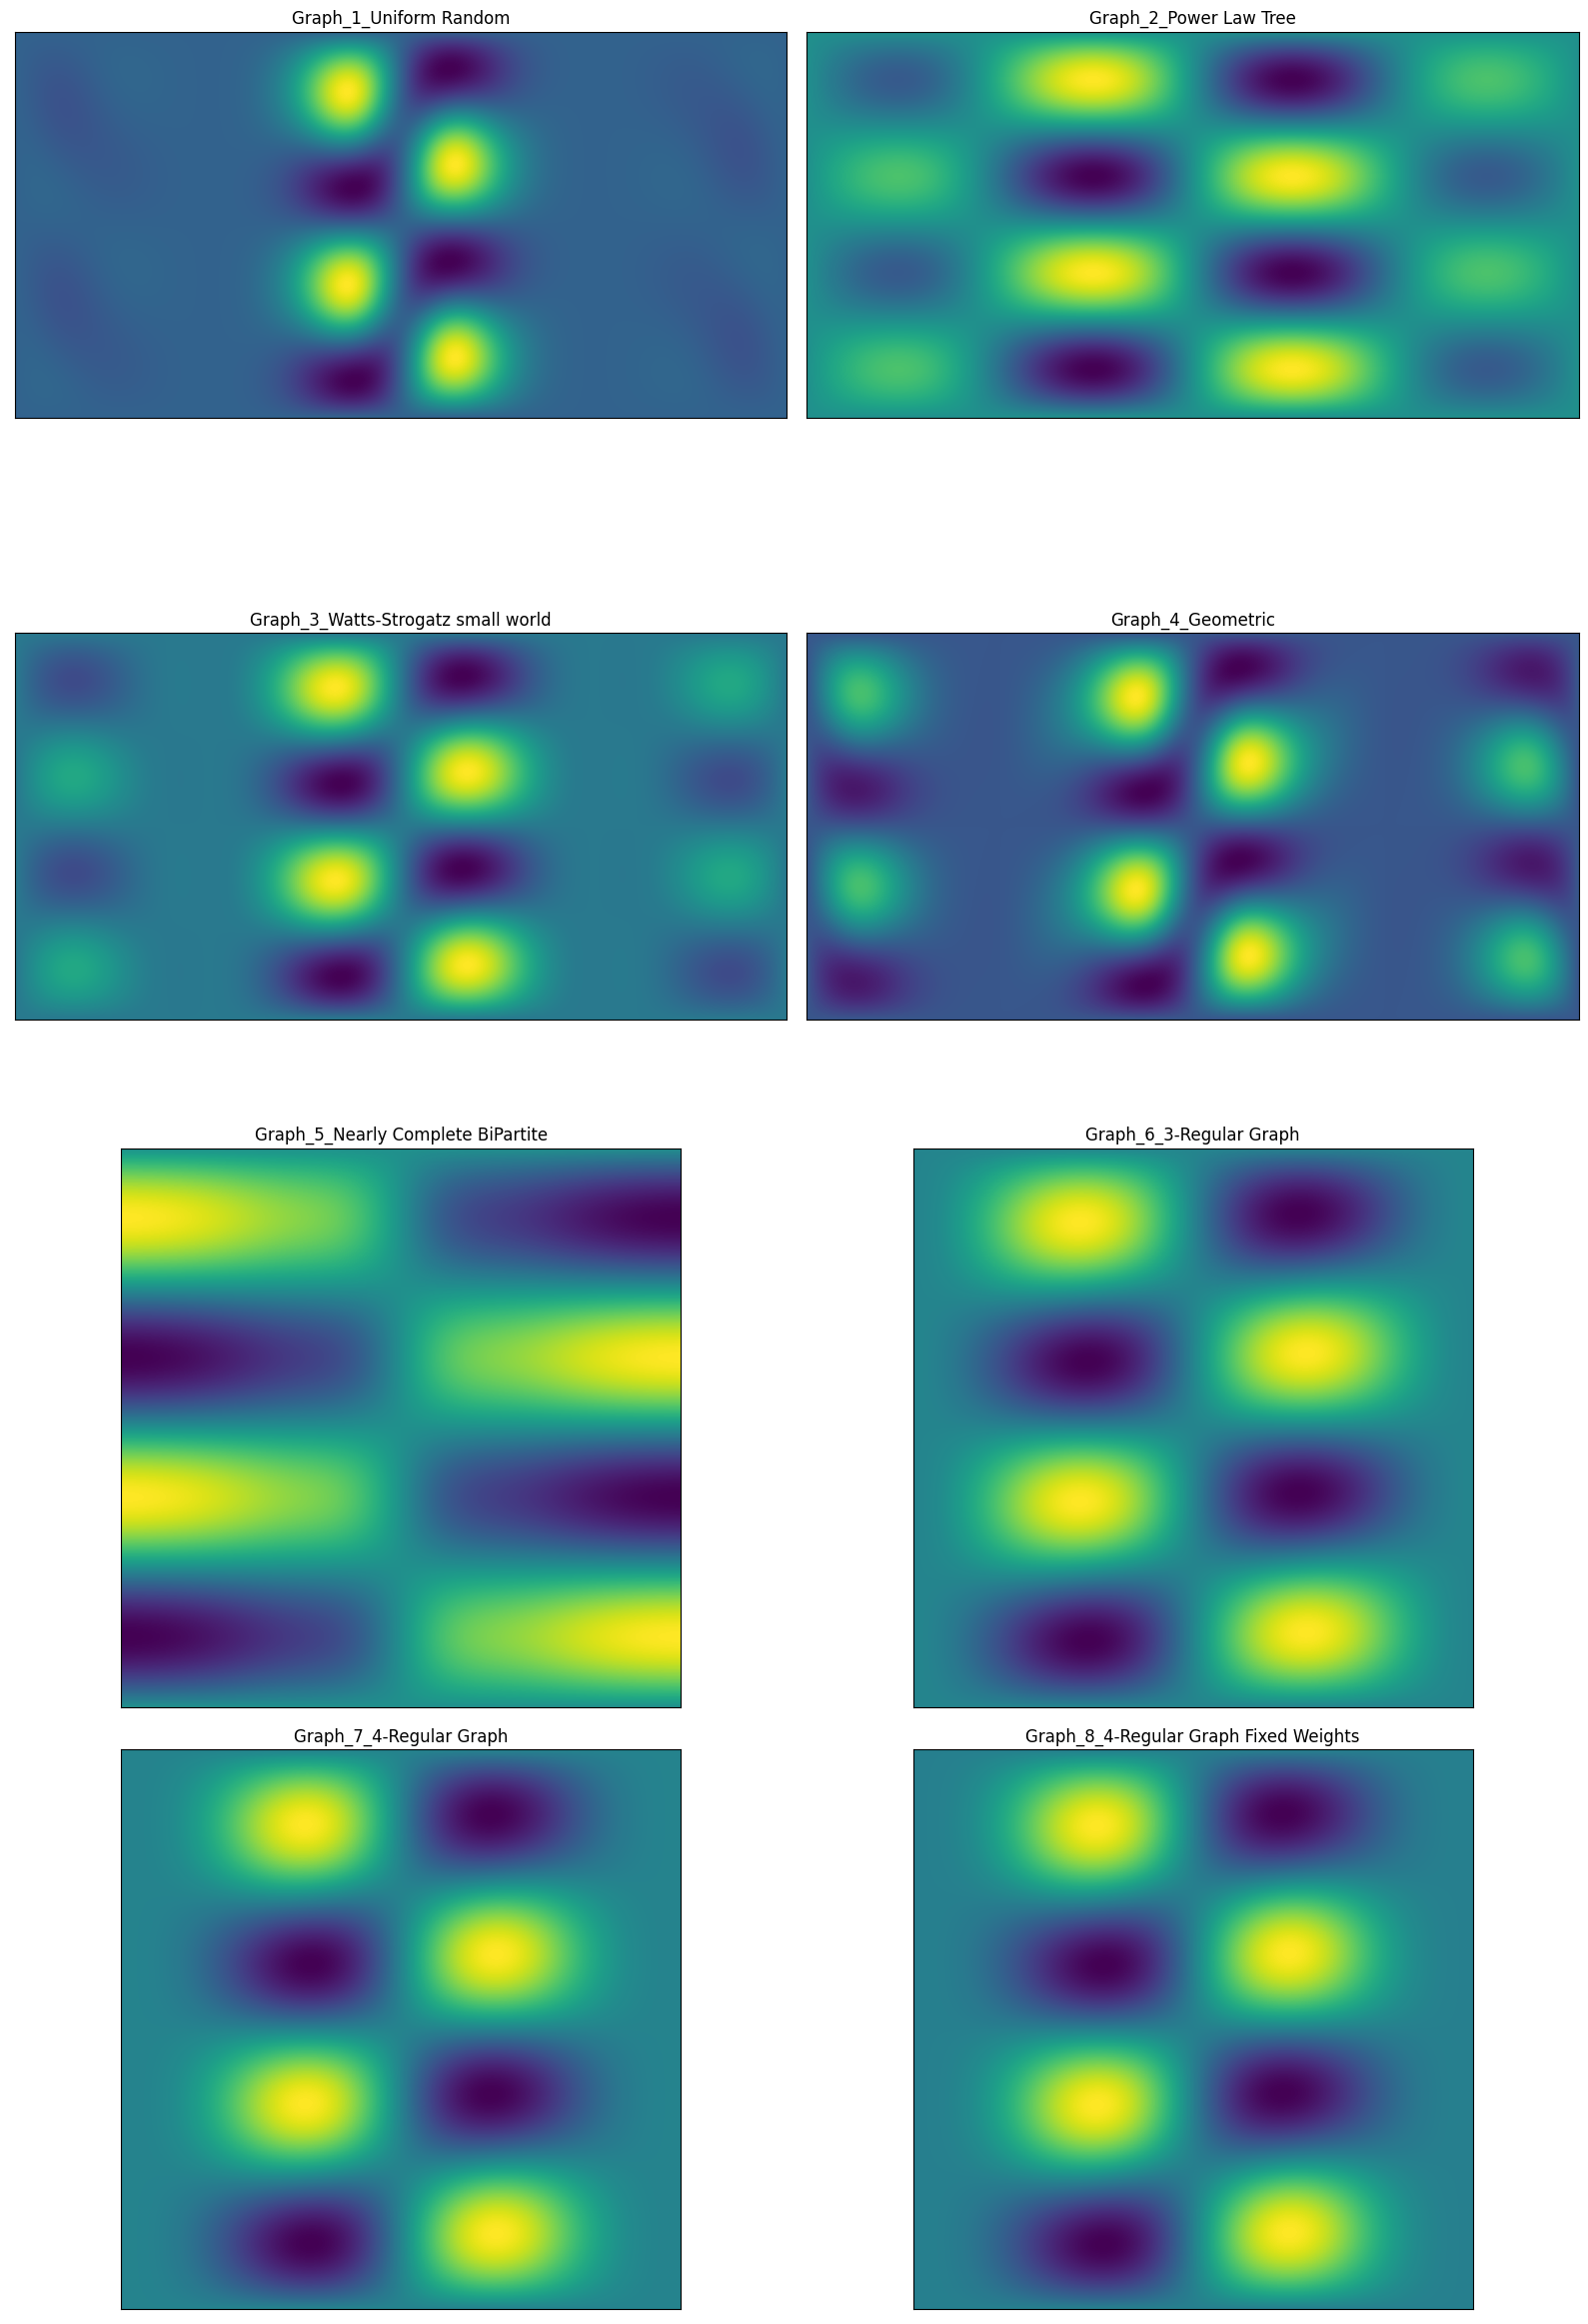

In [24]:
import math
# Determine the number of rows and columns for the subplots
num_graphs = len(landscape_data_storage)
num_cols = 2  # You can change this to whatever layout you prefer
num_rows = math.ceil(num_graphs / num_cols)

# Create a figure for the subplots
fig, axs = plt.subplots(num_rows, num_cols, figsize=(8 * num_cols, 6 * num_rows))

# Flatten the axes array for easy iteration if it's multidimensional
if num_graphs > 1:
    axs = axs.flatten()
else:
    axs = [axs]

# Loop through the stored landscape data and create subplots
for idx, (graph_key, landscape_data) in enumerate(landscape_data_storage.items()):
    fig_i, ax_i = plot_landscape(landscape_data, show_ticks=False)
    ax = axs[idx]
    
    # Copy the content of ax_i to the subplot's axis ax
    ax.imshow(landscape_data['obj_vals'].T, origin='lower', cmap='viridis', extent=(landscape_data['beta'][0], landscape_data['beta'][-1], landscape_data['gamma'][0], landscape_data['gamma'][-1]))
    ax.set_xlabel(ax_i.get_xlabel())
    ax.set_ylabel(ax_i.get_ylabel())
    ax.set_xticks(ax_i.get_xticks())
    ax.set_yticks(ax_i.get_yticks())
    ax.set_xticklabels(ax_i.get_xticklabels())
    ax.set_yticklabels(ax_i.get_yticklabels())
    title = graph_key.str_rel
    ax.set_title(f"{graph_key}")

    # Remove the individual figure to prevent it from showing separately
    plt.close(fig_i)

# Adjust the layout of the subplots
plt.tight_layout()


# Maximum Values at $p=1$ for each instance

In [44]:
import numpy as np
import json 
max_values = {}

for graph_name, graph_data in landscape_data_storage.items():
    beta = np.array(graph_data['beta'])  # Assuming this is a 1D array of length 400
    gamma = np.array(graph_data['gamma'])  # Assuming this is a 1D array of length 400
    obj_vals = np.array(graph_data['obj_vals'])  # A 400x400 array

    # Check if the dimensions match
    if obj_vals.shape == (len(beta), len(gamma)):
        overall_max_obj_val = -np.inf
        max_beta = None
        max_gamma = None

        for i, beta_val in enumerate(beta):
            max_index_gamma = np.argmax(obj_vals[i])
            max_obj_val = obj_vals[i][max_index_gamma]

            if max_obj_val > overall_max_obj_val:
                overall_max_obj_val = max_obj_val
                max_beta = beta_val
                max_gamma = gamma[max_index_gamma]

        max_values[graph_name] = {'beta': max_beta, 'gamma': max_gamma, 'max_obj_val': overall_max_obj_val}
    else:
        print(f"Data mismatch in {graph_name}: Cannot process obj_vals with shape {obj_vals.shape} to match beta ({len(beta)}) and gamma ({len(gamma)})")

print(json.dumps(max_values, indent=2))

{
  "Graph_1_Uniform Random": {
    "beta": -0.4487989505128276,
    "gamma": 2.653425374084612,
    "max_obj_val": 6.63015102408963
  },
  "Graph_2_Power Law Tree": {
    "beta": -0.8109875772424777,
    "gamma": 2.74790936366626,
    "max_obj_val": 2.7990407799338946
  },
  "Graph_3_Watts-Strogatz small world": {
    "beta": 0.5432829400944756,
    "gamma": 0.44092528471435694,
    "max_obj_val": 4.678926844260799
  },
  "Graph_4_Geometric": {
    "beta": 0.4645462821097688,
    "gamma": 2.0865214365947247,
    "max_obj_val": 7.3418364169301205
  },
  "Graph_5_Nearly Complete BiPartite": {
    "beta": -1.5707963267948966,
    "gamma": 2.74790936366626,
    "max_obj_val": 2.7499786893792146
  },
  "Graph_6_3-Regular Graph": {
    "beta": 0.641703762575359,
    "gamma": 0.417304287318945,
    "max_obj_val": 3.8190315363015594
  },
  "Graph_7_4-Regular Graph": {
    "beta": 0.5393461071952403,
    "gamma": 1.9920374470130768,
    "max_obj_val": 4.345701791650978
  },
  "Graph_8_4-Regula

# Minimum Values at $p=1$ for each instance

In [46]:
import numpy as np

min_values = {}

for graph_name, graph_data in landscape_data_storage.items():
    beta = np.array(graph_data['beta'])  # Assuming this is a 1D array of length 400
    gamma = np.array(graph_data['gamma'])  # Assuming this is a 1D array of length 400
    obj_vals = np.array(graph_data['obj_vals'])  # A 400x400 array

    # Check if the dimensions match
    if obj_vals.shape == (len(beta), len(gamma)):
        overall_min_obj_val = np.inf
        min_beta = None
        min_gamma = None

        for i, beta_val in enumerate(beta):
            min_index_gamma = np.argmin(obj_vals[i])
            min_obj_val = obj_vals[i][min_index_gamma]

            if min_obj_val < overall_min_obj_val:
                overall_min_obj_val = min_obj_val
                min_beta = beta_val
                min_gamma = gamma[min_index_gamma]

        min_values[graph_name] = {'beta': min_beta, 'gamma': min_gamma, 'min_obj_val': overall_min_obj_val}
    else:
        print(f"Data mismatch in {graph_name}: Cannot process obj_vals with shape {obj_vals.shape} to match beta ({len(beta)}) and gamma ({len(gamma)})")

print(json.dumps(min_values, indent=2))

{
  "Graph_1_Uniform Random": {
    "beta": 0.38580962412506237,
    "gamma": 2.842393353247908,
    "min_obj_val": -3.05644641636192
  },
  "Graph_2_Power Law Tree": {
    "beta": 0.8109875772424782,
    "gamma": 2.74790936366626,
    "min_obj_val": -2.7990407799338963
  },
  "Graph_3_Watts-Strogatz small world": {
    "beta": -0.4960409453036516,
    "gamma": 0.34644129513270905,
    "min_obj_val": -3.154358591482431
  },
  "Graph_4_Geometric": {
    "beta": 0.3700622925281212,
    "gamma": 1.2912811909491881,
    "min_obj_val": -2.7082934636401
  },
  "Graph_5_Nearly Complete BiPartite": {
    "beta": 1.5707963267948966,
    "gamma": 2.74790936366626,
    "min_obj_val": -2.7499786893792146
  },
  "Graph_6_3-Regular Graph": {
    "beta": -0.5944617677845347,
    "gamma": 0.370062292528121,
    "min_obj_val": -3.151595105476997
  },
  "Graph_7_4-Regular Graph": {
    "beta": -0.5078514440013575,
    "gamma": 1.9369217864237822,
    "min_obj_val": -3.501549074766393
  },
  "Graph_8_4-R